In [3]:
import pandas as pd
import plotly.express as px

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
food_train=pd.read_csv('data/food_train.csv')
food_test=pd.read_csv('data/food_test.csv')
nutri=pd.read_csv('data/nutrients.csv')
food_nutri=pd.read_csv('data/food_nutrients.csv')

In [109]:
categories=list(food_train['category'].drop_duplicates()) #get the categories names

**Let's explore the nutrients in our snacks:**

In [26]:
nutrients = pd.merge(food_nutri, nutri, how='left',on='nutrient_id') #merge the nutrients with our food description

Distribution by Nutrient:

In [209]:
cnt_nutrients = nutrients.groupby('name')['idx'].count().reset_index()
cnt_nutrients.columns = ['nutrient', 'count']
cnt_nutrients = cnt_nutrients[cnt_nutrients['count'] > 10]
fig = px.histogram(cnt_nutrients.sort_values('count', ascending=False),y='nutrient',x='count',title='Nutrients count',width=800,height=800,log_x=True,labels={'nutrient':'Nutrient'})

fig.show()

Expectedly,Carbohydrates(sugar molecules), Lipids (fats),Energy, Proteins, Sodium, and Sugars lead in records.

Since each nutrient uses different units we converted nutrient measurements to grams(by converting mg and ug to grams) and analyzed the average for the top 5 nutrients per category.
We also looked at average energy in kcal separately.

In [62]:
nut_merge=pd.merge(food_train, nutrients, how='left', on='idx') #merge the nutrients data with our food train data

In [120]:
def convert_to_grams(row):
    if row['unit_name'] == 'MG':
        return row['amount'] * 0.001
    elif row['unit_name'] == 'UG':
        return row['amount'] * 0.000001
    else:
        return row['amount']

nut_merge['amount_converted'] = nut_merge.apply(convert_to_grams, axis=1)

filtered_data_g = nut_merge[nut_merge['unit_name'].isin(['G', 'MG', 'UG'])]
avg_amount_g = filtered_data_g.groupby(['category', 'name'])['amount_converted'].mean().reset_index()

top_avg_g = avg_amount_g.groupby('category').apply(lambda x: x.nlargest(5, 'amount_converted')).reset_index(drop=True)

fig = make_subplots(rows=3, cols=2, subplot_titles=top_avg_g['category'].unique(), shared_xaxes=False)

r, c = 1, 1
for category in top_avg_g['category'].unique():
    subset = top_avg_g[top_avg_g['category'] == category]
    fig.add_trace(go.Bar(x=subset['amount_converted'], y=subset['name'], orientation='h', name=category), row=r, col=c)
    fig.update_xaxes(type="log", row=r, col=c)
    c += 1
    if c > 2:
        c = 1
        r += 1

fig.update_layout(title_text='Top 5 Nutrients by Average Amount in Each Category (in Grams)', showlegend=False, height=900)
fig.show()



We can see that chocolates, cookies, and candies have more sugar, while salty snacks have more fats and starch but less sugar.


In [95]:
energy_data = nut_merge[(nut_merge['name'] == 'Energy') & (nut_merge['unit_name'] == 'KCAL')]
avg_energy = energy_data.groupby('category')['amount'].mean().reset_index()

fig = go.Figure(go.Bar(x=avg_energy['category'], y=avg_energy['amount']))
fig.update_layout(title_text="Average Energy (KCAL) for Each Category", yaxis_title="Average Energy (KCAL)")
fig.show()


**Now let's explore the ingredients for each category:**

In [107]:
food_train['ingredients_list']=food_train['ingredients'].apply(lambda x :re.split(r',\s*(?![^()]*\))',str(x)))
food_train['len_ingredients']=food_train['ingredients_list'].str.len()
fig=px.histogram(food_train,x='len_ingredients',color='category',title="Number Of Ingredients By Category")
fig.show()

We can see that cakes and cupcakes have more ingredients than the other categories.
Popcorn and peanuts have fewer ingredients than other categories.

Now, lets explore for each category its common ingredients:

In [176]:
from string import punctuation
def clean_text_values(data, col):
    column_values = {}
    n=len(food_train)
    column_values[col] = food_train[col].value_counts().to_frame().reset_index()
    column_values[col].columns = ['value', 'count']
    column_values[col]['pc'] = column_values[col]['count'] / n * 100
    for col in column_values:
        data[col].str.encode('ascii', 'ignore').str.decode('ascii')
        data[col] = data[col].str.lower()
        data[col].fillna('NA', inplace=True)
        for p in punctuation:
            data[col] = data[col].str.replace(p, '', regex=False)
            data[col] = data[col].str.replace(r'\s+', ' ', regex=True)


    return data




In [177]:
food_train_2=food_train.copy()

In [178]:
clean_text_values(food_train_2,'ingredients')

,idx,brand,description,ingredients,serving_size,serving_size_unit,household_serving_fulltext,category,ingredients_list,len_ind,len_ingredients
0,1,brix chocolate,milk chocolate,sugar cocoa butter whole milk chocolate liquor...,28.0,g,1 onz,chocolate,"[sugar, cocoa butter, whole milk, chocolate li...",8,8
1,2,target stores,frosted sugar cookies,sugar enriched bleached wheat flour flour niac...,38.0,g,1 cookie,cookies_biscuits,"[sugar, enriched bleached wheat flour (flour, ...",34,34
2,3,target stores,white frosted mini sugar cookies,sugar enriched bleached wheat flour flour niac...,30.0,g,2 cookies,cookies_biscuits,"[sugar, enriched bleached wheat flour (flour, ...",35,35
3,4,target stores,chocolaty dipped graham crackers,sugar vegetable oil palm kernel partially hydr...,40.0,g,5 pieces,cookies_biscuits,"[sugar, vegetable oil (palm kernel, partially ...",21,21
4,5,"ferrero u.s.a., incorporated","ferrero collection, fine assorted confections",semisweet chocolate sugar cocoa mass cocoa but...,40.0,g,4 pieces,chocolate,"[semisweet chocolate (sugar, cocoa mass, cocoa...",49,49
...,...,...,...,...,...,...,...,...,...,...,...
31746,35272,"safeway, inc.","honey wheat pretzel braids, honey wheat",enriched wheat flour wheat flour niacin reduce...,28.0,g,1 onz,chips_pretzels_snacks,"[enriched wheat flour (wheat flour, niacin, re...",8,8
31747,35273,"safeway, inc.","candy, gummi bears",corn syrup sugar gelatin modified food starch ...,31.0,g,12 pieces,candy,"[corn syrup, sugar, gelatin, modified food sta...",13,13
31748,35274,"winn-dixie stores, inc.","potato chips, barbecue",potatoes vegetable oil corn andor canola andor...,28.0,g,1 onz,chips_pretzels_snacks,"[potatoes, vegetable oil (corn and/or canola a...",3,3
31749,35275,"winn-dixie stores, inc.","potato chips, sour cream & onion",potatoes vegetable oil corn andor canola andor...,28.0,g,1 onz,chips_pretzels_snacks,"[potatoes, vegetable oil (corn and/or canola a...",3,3


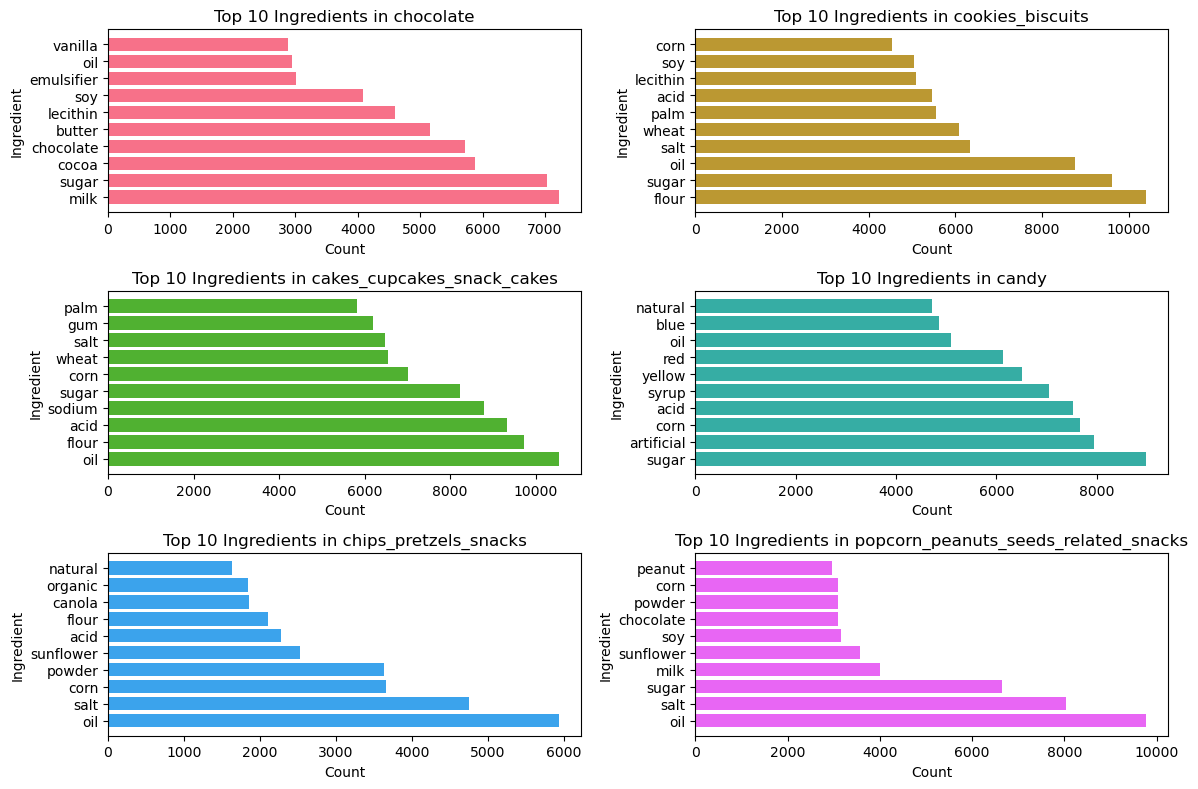

In [181]:
food_train_2['ingredients'] = food_train_2['ingredients'].astype(str)
ignore_words = {"and", "or", "of","andor"}

food_train_2['ingredients'] = food_train_2['ingredients'].str.split(' ').apply(lambda x: [word for word in x if word not in ignore_words and not word.isdigit()])
expanded_df = food_train_2.explode('ingredients')

ingredient_counts = expanded_df.groupby('category')['ingredients'].value_counts()
colors = sns.color_palette("husl", 6)
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

for ax, (category, color) in zip(axes.ravel(), zip(categories, colors)):
    top_ingredients = ingredient_counts[category].head(10)
    ax.barh(top_ingredients.index, top_ingredients.values, color=color)
    ax.set_title(f'Top 10 Ingredients in {category}')
    ax.set_xlabel('Count')
    ax.set_ylabel('Ingredient')

plt.tight_layout()
plt.show()



In the Candy section, we spot some colors which probably means they've got food coloring.
When we check out Salty Snacks, salt's right up there on the list,but you won't find it in the top 10 for candies and chocolates.
And it's no surprise that flour takes center stage in both the Cookies and Cakes categories.

**Let's do the same for the description:**

In [207]:
food_train_desc=food_train.copy()

In [208]:
clean_text_values(food_train_desc,'description')

,idx,brand,description,ingredients,serving_size,serving_size_unit,household_serving_fulltext,category,ingredients_list,len_ind,len_ingredients
0,1,brix chocolate,milk chocolate,"sugar, cocoa butter, whole milk, chocolate liq...",28.0,g,1 onz,chocolate,"[sugar, cocoa butter, whole milk, chocolate li...",8,8
1,2,target stores,frosted sugar cookies,"sugar, enriched bleached wheat flour (flour, n...",38.0,g,1 cookie,cookies_biscuits,"[sugar, enriched bleached wheat flour (flour, ...",34,34
2,3,target stores,white frosted mini sugar cookies,"sugar, enriched bleached wheat flour (flour, n...",30.0,g,2 cookies,cookies_biscuits,"[sugar, enriched bleached wheat flour (flour, ...",35,35
3,4,target stores,chocolaty dipped graham crackers,"sugar, vegetable oil (palm kernel, partially h...",40.0,g,5 pieces,cookies_biscuits,"[sugar, vegetable oil (palm kernel, partially ...",21,21
4,5,"ferrero u.s.a., incorporated",ferrero collection fine assorted confections,"semisweet chocolate (sugar, cocoa mass, cocoa ...",40.0,g,4 pieces,chocolate,"[semisweet chocolate (sugar, cocoa mass, cocoa...",49,49
...,...,...,...,...,...,...,...,...,...,...,...
31746,35272,"safeway, inc.",honey wheat pretzel braids honey wheat,"enriched wheat flour (wheat flour, niacin, red...",28.0,g,1 onz,chips_pretzels_snacks,"[enriched wheat flour (wheat flour, niacin, re...",8,8
31747,35273,"safeway, inc.",candy gummi bears,"corn syrup, sugar, gelatin, modified food star...",31.0,g,12 pieces,candy,"[corn syrup, sugar, gelatin, modified food sta...",13,13
31748,35274,"winn-dixie stores, inc.",potato chips barbecue,"potatoes, vegetable oil (corn and/or canola an...",28.0,g,1 onz,chips_pretzels_snacks,"[potatoes, vegetable oil (corn and/or canola a...",3,3
31749,35275,"winn-dixie stores, inc.",potato chips sour cream onion,"potatoes, vegetable oil (corn and/or canola an...",28.0,g,1 onz,chips_pretzels_snacks,"[potatoes, vegetable oil (corn and/or canola a...",3,3


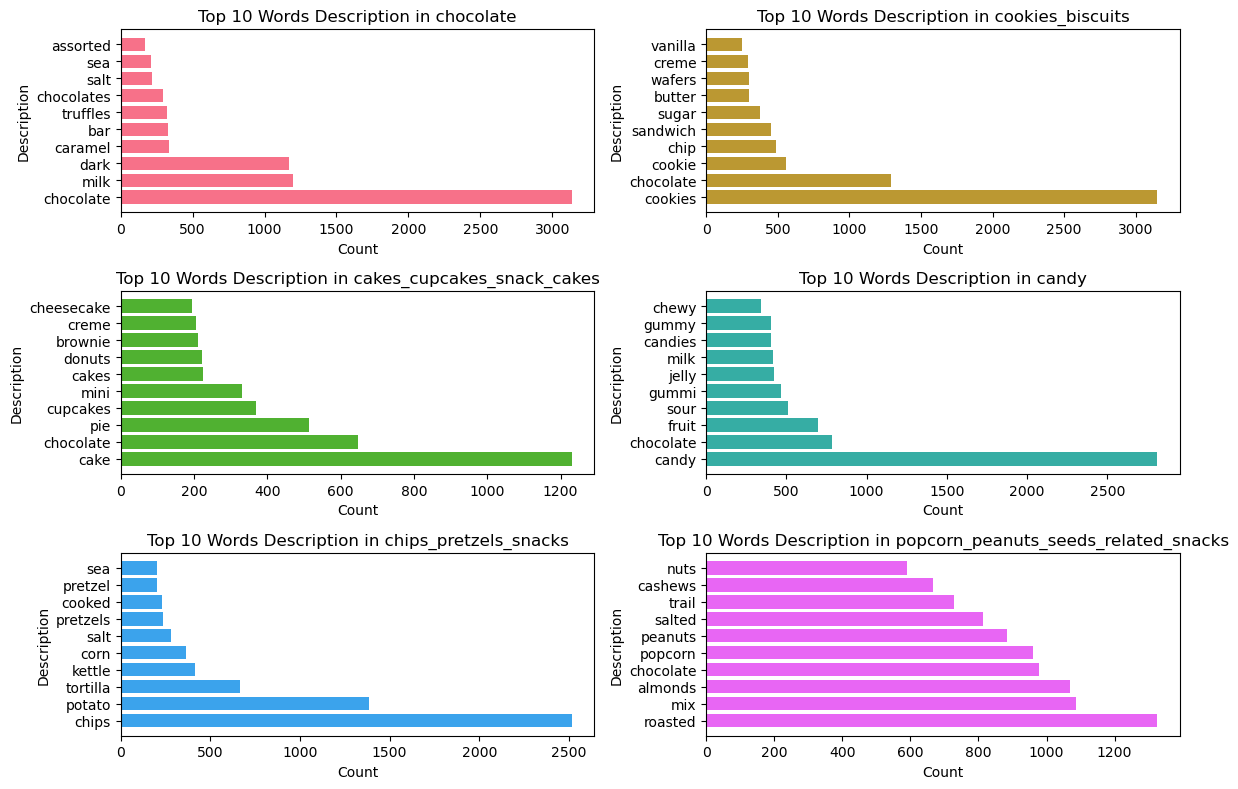

In [194]:
import matplotlib.pyplot as plt
food_train_desc['description'] = food_train_desc['description'].astype(str)
ignore_words = {"and", "or", "of","andor","with"}

food_train_desc['description'] = food_train_desc['description'].str.split(' ').apply(lambda x: [word for word in x if word not in ignore_words and not word.isdigit()])
expanded_df = food_train_desc.explode('description')

words_counts = expanded_df.groupby('category')['description'].value_counts()
colors = sns.color_palette("husl", 6)
fig, axes = plt.subplots(3, 2, figsize=(12, 8))

for ax, (category, color) in zip(axes.ravel(), zip(categories, colors)):
    top_words = words_counts[category].head(10)
    ax.barh(top_words.index, top_words.values, color=color)
    ax.set_title(f'Top 10 Words Description in {category}')
    ax.set_xlabel('Count')
    ax.set_ylabel('Description')

plt.tight_layout()
plt.show()



Chocolate pops up a lot in the descriptions of chocolate, cookies, and cakes - which means it might not be a reliable predictor.
No shocker, cake, pie, and cupcakes are leading the cakes category.
For the candy category, descriptions like candy, gummy, and jelly could be strong indicators.
And for chip snacks, chips, potato, and tortilla taking the spotlight.

**Now we'll explore the Brands**

In [221]:

top_brands=food_train['brand'].value_counts()[:100].index.tolist()

brands_segments = [top_brands[i:i + 25] for i in range(0, 100, 25)]

top_brands_t=food_train[food_train['brand'].isin(top_brands)].groupby(['brand','category'])['idx'].count().to_frame().reset_index()

In [230]:

brands_4_plots = [top_brands[i:i + 25] for i in range(0, 100, 25)]


for idx, brands in enumerate(brands_4_plots, 1):
    brand_data = top_brands_t.set_index('brand').loc[brands]
    fig = px.bar(brand_data, x=brand_data.index, y="idx", color="category", title=f"Distribution of Categories by Top Brands ({idx*25-24}-{idx*25})")
    fig.show()


We notice that there are some companies that sells mostly products from 1 category.
Let's explore them:

In [232]:
total_counts = food_train.groupby('brand')['idx'].count()
category_counts = food_train.groupby(['brand', 'category'])['idx'].count()

# Brands selling > 90% in one category
one_cat_brands = category_counts[category_counts / total_counts.groupby(level=0).transform('max') >= 0.9].reset_index()['brand'].unique()
one_cat_top_brands = [brand for brand in top_brands if brand in one_cat_brands]
one_cat_brands_data = food_train[food_train['brand'].isin(one_cat_top_brands)].groupby(['brand', 'category'])['idx'].count().reset_index()

fig = px.bar(one_cat_brands_data, x="brand", y="idx", color="category", title="Brands Specializing in One Category")
fig.show()


We can use this information later on in our model to classify the categories.
